# Test TimeSeriesForest

## Importation

In [45]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np

In [46]:
def downsample(L, n):
    return [x for i,x in enumerate(L) if i%n ==0]
downsample([1,2,3,4,5,6,7,8],2)

[1, 3, 5, 7]

In [47]:
data_path = "../../../residuals-fault-detection/data/"
categories = listdir(data_path)
X = pd.DataFrame()
Y = []
for cat in categories:
    tmp = join(data_path, cat)
    files = [f for f in listdir(tmp) if isfile(join(tmp, f))]
    n_samples = 45
    if cat == 'fault_less':
        n_samples*= 11
    else:
        cat = 'fault'
    for i in range(min(len(files),n_samples)):
        file = files[i]
        serie = pd.read_csv(join(tmp, file), names=['t', 'i', 'w'])
        i_data=downsample(serie[['i']].values.flatten(),15)
        w_data=downsample(serie[['w']].values.flatten(),15)
        d = {'i': [pd.Series(i_data, copy=False)], 'w': [pd.Series(w_data, copy=False)]}
        df_tmp = pd.DataFrame(data=d)
        X = pd.concat([X, df_tmp], ignore_index = True)
        Y.append(cat)

Y = np.array(Y)

In [48]:
X.head()

,i,w
0,0 0.043661 1 35.388852 2 31.92146...,0 -0.113491 1 15.714004 2 24.49201...
1,0 -0.092780 1 35.364748 2 31.97551...,0 0.060203 1 15.755528 2 24.50619...
2,0 0.093331 1 35.457204 2 32.07400...,0 0.038985 1 15.525533 2 24.43072...
3,0 0.025564 1 35.399243 2 32.08137...,0 0.095591 1 15.646874 2 24.60905...
4,0 0.032729 1 35.382107 2 31.99763...,0 -0.069286 1 15.612040 2 24.52444...


In [49]:
Y[:5]

array(['fault', 'fault', 'fault', 'fault', 'fault'], dtype='<U10')

## Entrainement du modèle

In [50]:

from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sktime.classification.compose import ColumnEnsembleClassifier

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [52]:
tsf = TimeSeriesForestClassifier()
estimators = [("TSF 1", tsf, [0]),("TSF 2", tsf, [1])]
classifier = ColumnEnsembleClassifier(estimators=estimators)
classifier.fit(X_train, y_train)

ColumnEnsembleClassifier(estimators=[('TSF 1', TimeSeriesForestClassifier(),
                                      [0]),
                                     ('TSF 2', TimeSeriesForestClassifier(),
                                      [1])])

Cela a pris 1min de compilation.

## Evaluation

In [53]:
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7741935483870968


In [54]:
labels = classifier.classes_

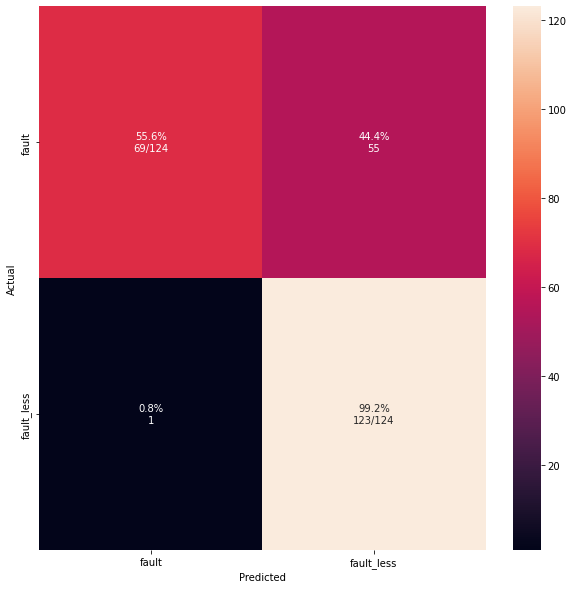

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

cm_analysis(y_test, y_pred, classifier.classes_, ymap=None, figsize=(10,10))